# Packages

In [217]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
from tqdm.notebook import tqdm
import itertools
import yaml
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)

theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Read Holdout Predictions

In [218]:
prediction_paths = [path for path in os.listdir() if "holdout_predictions" in path]
prediction_paths

['3_SARIMAX_holdout_predictions_no_retraining.csv',
 '4_NBEATSX_holdout_predictions_no_retraining.csv',
 '4_NBEATSX_holdout_predictions_with_retraining.csv',
 '5_RIDGE_holdout_predictions_no_retraining.csv',
 '5_RIDGE_holdout_predictions_with_retraining.csv',
 '6_NAIVE_holdout_predictions.csv',
 '7_ANN_holdout_predictions_no_retraining.csv',
 '7_ANN_holdout_predictions_with_retraining.csv',
 '8_LGBM_holdout_predictions_no_retraining.csv',
 '8_LGBM_holdout_predictions_with_retraining.csv']

In [219]:
results = (
    pd.concat(
        [
            # SARIMAX
            pd.read_csv("3_SARIMAX_holdout_predictions_no_retraining.csv").assign(
                model="SARIMAX", retraining="no"
            ),
            # NBEATSx
            pd.read_csv("4_NBEATSX_holdout_predictions_no_retraining.csv").assign(
                model="NBEATSx", retraining="no"
            ),
            pd.read_csv("4_NBEATSX_holdout_predictions_with_retraining.csv").assign(
                model="NBEATSx", retraining="yes"
            ),
            # RIDGE
            pd.read_csv("5_RIDGE_holdout_predictions_no_retraining.csv").assign(
                model="RIDGE", retraining="no"
            ),
            pd.read_csv("5_RIDGE_holdout_predictions_with_retraining.csv").assign(
                model="RIDGE", retraining="yes"
            ),
            # NAIVE
            pd.read_csv("6_NAIVE_holdout_predictions.csv").assign(
                model="NAIVE", retraining="yes"
            ),
            # ANN
            pd.read_csv("7_ANN_holdout_predictions_no_retraining.csv").assign(
                model="DNN", retraining="no"
            ),
            pd.read_csv("7_ANN_holdout_predictions_with_retraining.csv").assign(
                model="DNN", retraining="yes"
            ),
            # LGBM
            pd.read_csv("8_LGBM_holdout_predictions_no_retraining.csv").assign(
                model="LGBM", retraining="no"
            ),
            pd.read_csv("8_LGBM_holdout_predictions_with_retraining.csv").assign(
                model="LGBM", retraining="yes"
            ),
        ],
        axis=0,
    )
    .reset_index(drop=True)
    .assign(datetime=lambda x: pd.to_datetime(x.datetime))
)


results

,datetime,pred,kWh,model,retraining
0,2023-09-01 00:00:00,4.998854e+06,4.952079e+06,SARIMAX,no
1,2023-09-01 01:00:00,4.780058e+06,4.789383e+06,SARIMAX,no
2,2023-09-01 02:00:00,4.668213e+06,4.689283e+06,SARIMAX,no
3,2023-09-01 03:00:00,4.478623e+06,4.490485e+06,SARIMAX,no
4,2023-09-01 04:00:00,4.359756e+06,4.345052e+06,SARIMAX,no
...,...,...,...,...,...
87835,2024-08-31 19:00:00,5.279777e+06,5.361417e+06,LGBM,yes
87836,2024-08-31 20:00:00,5.337827e+06,5.377510e+06,LGBM,yes
87837,2024-08-31 21:00:00,5.197232e+06,5.213034e+06,LGBM,yes
87838,2024-08-31 22:00:00,5.127580e+06,5.076693e+06,LGBM,yes


# Bagged Model

In [220]:
bagged_preds = (
    pl.from_pandas(results)
    .filter(~pl.col("model").is_in(["NAIVE"]))
    .group_by("datetime")
    .agg(pred=pl.mean("pred"))
    .join(
        pl.from_pandas(results).select("datetime", "kWh").unique("datetime"),
        how="left",
        on="datetime",
    )
    .sort("datetime")
    .with_columns(model=pl.lit("BAGGED"), retraining=pl.lit("yes"))
    .to_pandas()
)

bagged_preds.head()

,datetime,pred,kWh,model,retraining
0,2023-09-01 00:00:00,5.015861e+06,4.952079e+06,BAGGED,yes
1,2023-09-01 01:00:00,4.865597e+06,4.789383e+06,BAGGED,yes
2,2023-09-01 02:00:00,4.764405e+06,4.689283e+06,BAGGED,yes
3,2023-09-01 03:00:00,4.620479e+06,4.490485e+06,BAGGED,yes
4,2023-09-01 04:00:00,4.506306e+06,4.345052e+06,BAGGED,yes


In [221]:
results = pd.concat([results, bagged_preds], axis=0)

# Check Holdout Length

In [222]:
results.value_counts(["model", "retraining"]).reset_index()

,model,retraining,count
0,BAGGED,yes,8784
1,DNN,no,8784
2,DNN,yes,8784
3,LGBM,no,8784
4,LGBM,yes,8784
5,NAIVE,yes,8784
6,NBEATSx,no,8784
7,NBEATSx,yes,8784
8,RIDGE,no,8784
9,RIDGE,yes,8784


# Visualisations of Metrics

## Full Period

- Table in paper

In [223]:
with pd.option_context("display.max_rows", 500):
    print(
        pl.from_pandas(results)
        .group_by(["model", "retraining"])
        .agg(
            rmse=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt(),
            mae=(pl.col("pred") - pl.col("kWh")).abs().mean(),
            mape=((pl.col("pred") - pl.col("kWh")).abs() / pl.col("kWh")).mean(),
        )
        .sort("rmse")
        .to_pandas()
    )

      model retraining           rmse            mae      mape
0    BAGGED        yes  247348.871939  169264.343138  0.028316
1      LGBM        yes  252853.239639  177004.175074  0.029156
2      LGBM         no  258495.911041  182955.293451  0.030148
3       DNN         no  289389.359265  191460.002639  0.031998
4       DNN        yes  313062.025573  205231.402268  0.034267
5   NBEATSx        yes  329167.891102  211192.194796  0.035944
6   NBEATSx         no  334556.047832  216563.496851  0.037242
7     RIDGE        yes  335067.878576  257353.523001  0.043985
8     RIDGE         no  338158.505778  261399.098936  0.044795
9   SARIMAX         no  372167.118468  237101.206140  0.038784
10    NAIVE        yes  590135.638559  421695.809310  0.068868


## By Calendar Variable

- by hour in day
- by weekday
- by month

### Aggregated

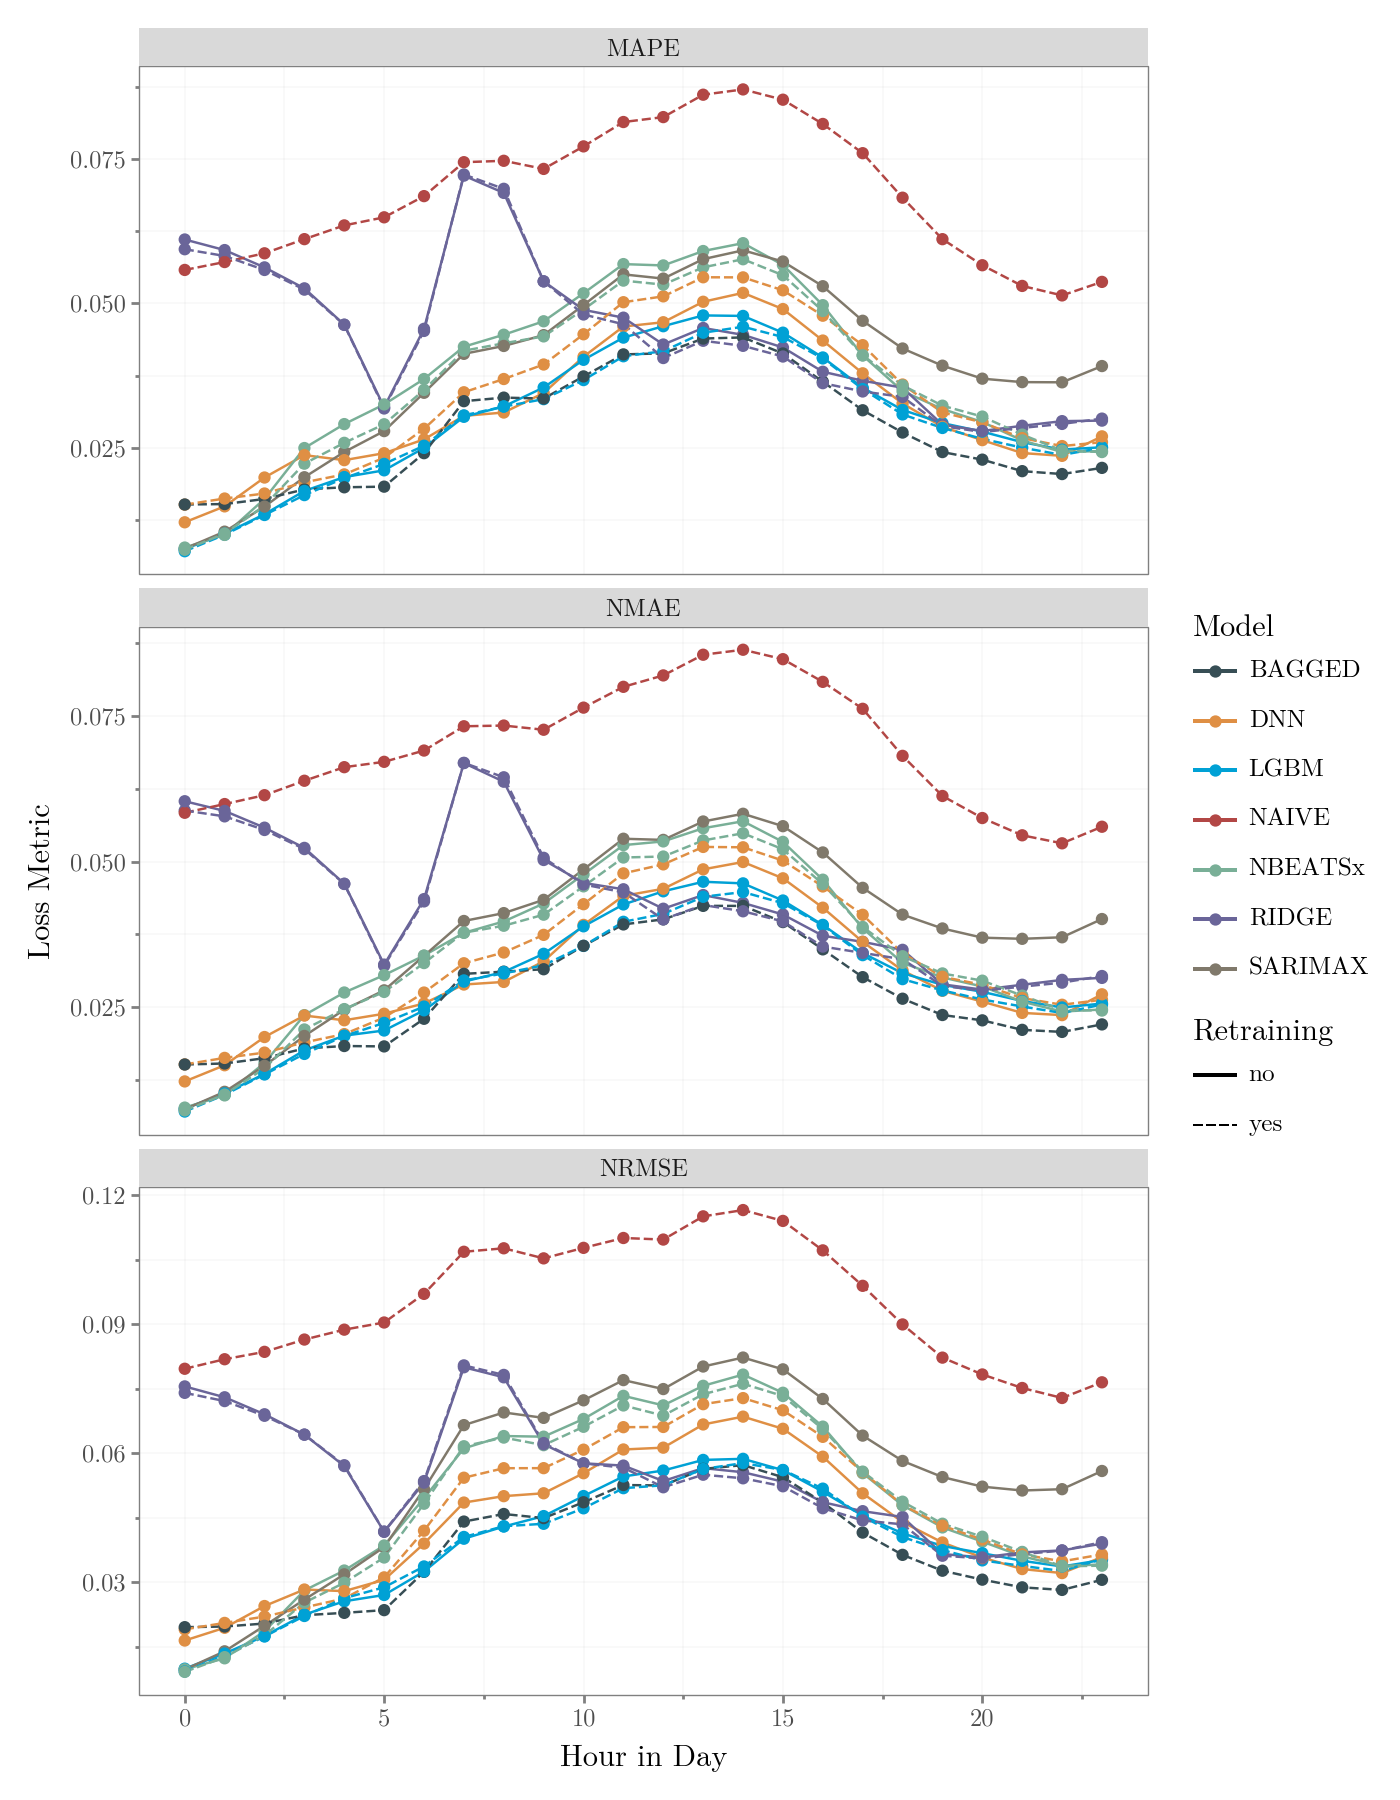

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 9 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/holdout_metrics_by_hour.pdf


In [224]:
plot_width = 7
plot_height = 9

fig = (
    pn.ggplot(
        data=(
            pl.from_pandas(results)
            .with_columns(hour=pl.col("datetime").dt.hour())
            .group_by(["hour", "model", "retraining"])
            .agg(
                NRMSE=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt()
                / pl.mean("kWh"),
                NMAE=(pl.col("pred") - pl.col("kWh")).abs().mean() / pl.mean("kWh"),
                MAPE=((pl.col("pred") - pl.col("kWh")).abs() / pl.col("kWh")).mean(),
            )
            .unpivot(index=["hour", "model", "retraining"])
        ),
        mapping=pn.aes("hour", "value", colour="model", linetype="retraining"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(x="Hour in Day", y="Loss Metric", colour="Model", linetype="Retraining")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.facet_wrap("~ variable", ncol=1, scales="free_y")
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/holdout_metrics_by_hour.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

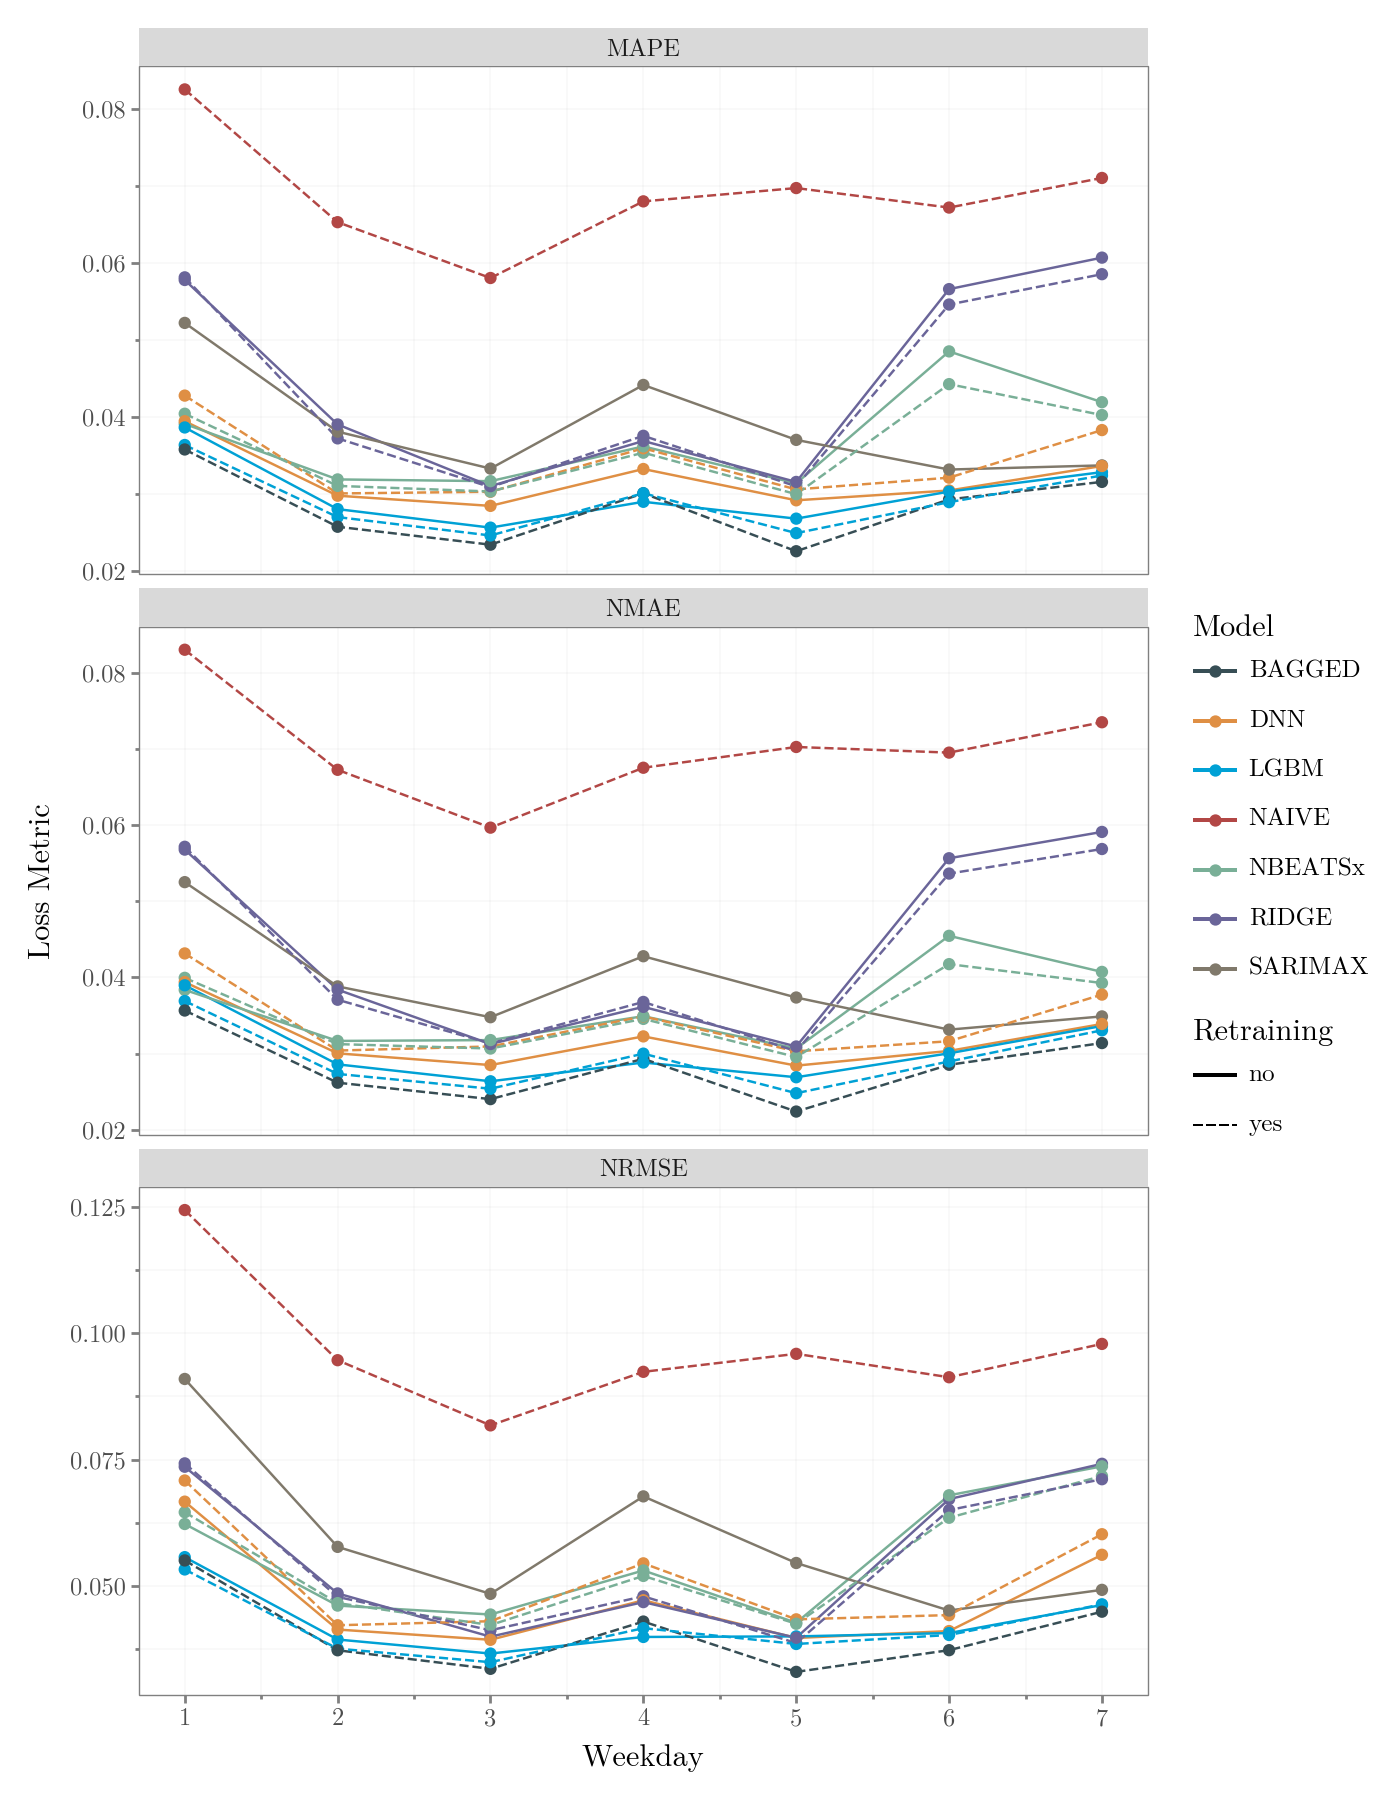

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 9 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/holdout_metrics_by_weekday.pdf


In [225]:
plot_width = 7
plot_height = 9

fig = (
    pn.ggplot(
        data=(
            pl.from_pandas(results)
            .with_columns(weekday=pl.col("datetime").dt.weekday())
            .group_by(["weekday", "model", "retraining"])
            .agg(
                NRMSE=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt()
                / pl.mean("kWh"),
                NMAE=(pl.col("pred") - pl.col("kWh")).abs().mean() / pl.mean("kWh"),
                MAPE=((pl.col("pred") - pl.col("kWh")).abs() / pl.col("kWh")).mean(),
            )
            .unpivot(index=["weekday", "model", "retraining"])
        ),
        mapping=pn.aes("weekday", "value", colour="model", linetype="retraining"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(x="Weekday", y="Loss Metric", colour="Model", linetype="Retraining")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_continuous(breaks=np.arange(1, 7 + 1))
    + pn.facet_wrap("~ variable", ncol=1, scales="free_y")
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/holdout_metrics_by_weekday.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

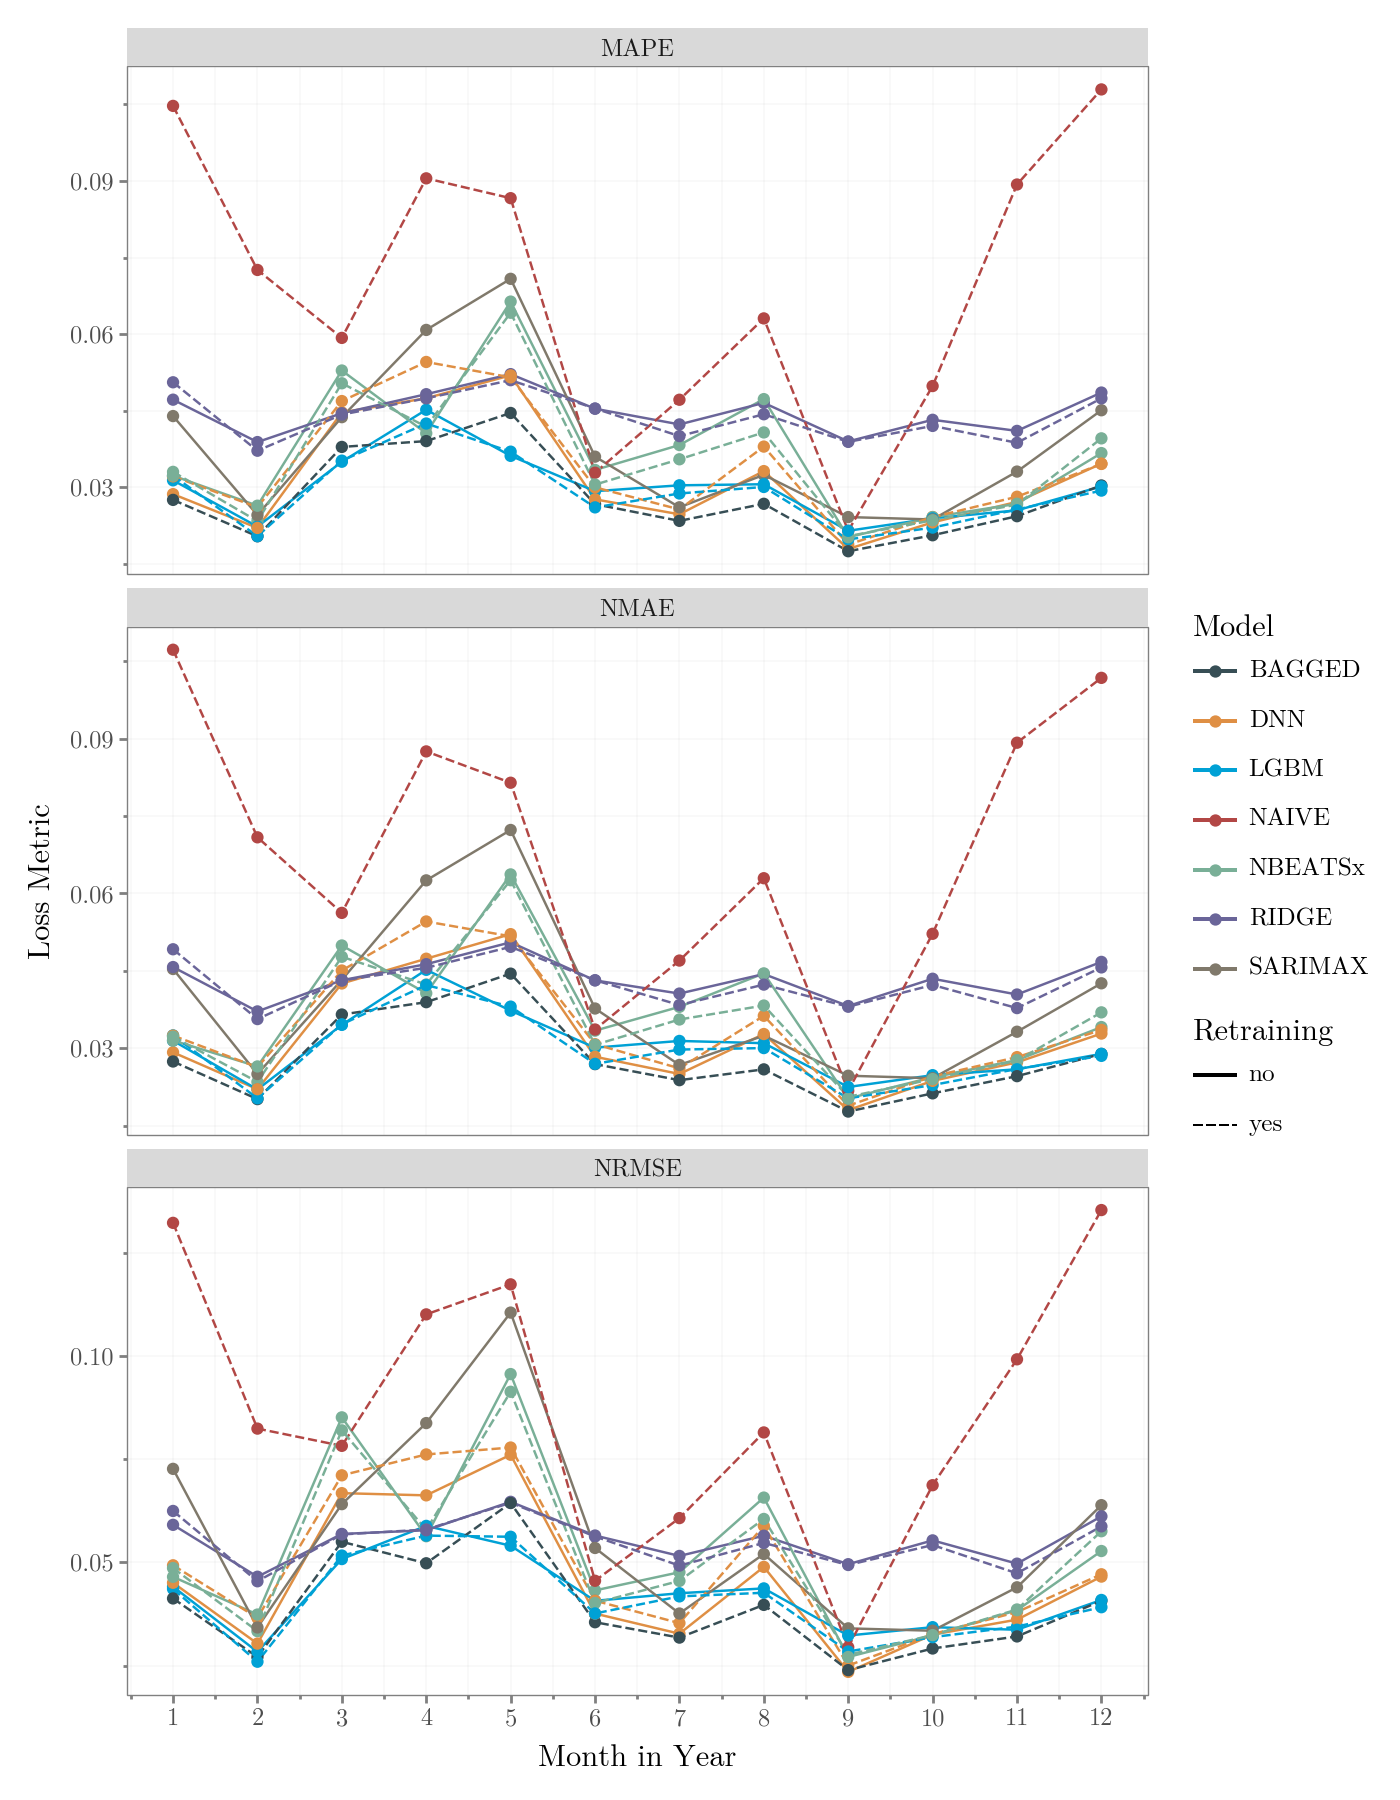

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 9 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/holdout_metrics_by_month.pdf


In [226]:
plot_width = 7
plot_height = 9

fig = (
    pn.ggplot(
        data=(
            pl.from_pandas(results)
            .with_columns(month=pl.col("datetime").dt.month())
            .group_by(["month", "model", "retraining"])
            .agg(
                NRMSE=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt()
                / pl.mean("kWh"),
                NMAE=(pl.col("pred") - pl.col("kWh")).abs().mean() / pl.mean("kWh"),
                MAPE=((pl.col("pred") - pl.col("kWh")).abs() / pl.col("kWh")).mean(),
            )
            .unpivot(index=["month", "model", "retraining"])
        ),
        mapping=pn.aes("month", "value", colour="model", linetype="retraining"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(x="Month in Year", y="Loss Metric", colour="Model", linetype="Retraining")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_continuous(breaks=np.arange(1, 12 + 1))
    + pn.facet_wrap("~ variable", ncol=1, scales="free_y")
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/holdout_metrics_by_month.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

# Visualisation of Predictions

## Full Period

In [242]:
best_weeks = (
    pl.from_pandas(results)
    .with_columns(target_week=pl.col("datetime").dt.truncate("1w"))
    .group_by(["target_week", "model", "retraining"])
    .agg(
        loss=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt(),
    )
    .sort(["model", "retraining", "loss"])
    .group_by(["model", "retraining"])
    .head(1)
    .drop("loss")
)

best_weeks.head()

model,retraining,target_week
str,str,datetime[ns]
"""NBEATSx""","""no""",2023-09-11 00:00:00
"""BAGGED""","""yes""",2023-09-04 00:00:00
"""LGBM""","""yes""",2023-09-11 00:00:00
"""DNN""","""yes""",2023-09-04 00:00:00
"""LGBM""","""no""",2023-09-11 00:00:00


In [243]:
worst_weeks = (
    pl.from_pandas(results)
    .with_columns(target_week=pl.col("datetime").dt.truncate("1w"))
    .group_by(["target_week", "model", "retraining"])
    .agg(
        loss=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt(),
    )
    .sort(["model", "retraining", "loss"])
    .group_by(["model", "retraining"])
    .tail(1)
    .drop("loss")
)

worst_weeks.head()

model,retraining,target_week
str,str,datetime[ns]
"""LGBM""","""yes""",2024-03-25 00:00:00
"""RIDGE""","""yes""",2024-01-22 00:00:00
"""NAIVE""","""yes""",2023-12-25 00:00:00
"""SARIMAX""","""no""",2024-01-08 00:00:00
"""LGBM""","""no""",2024-03-25 00:00:00


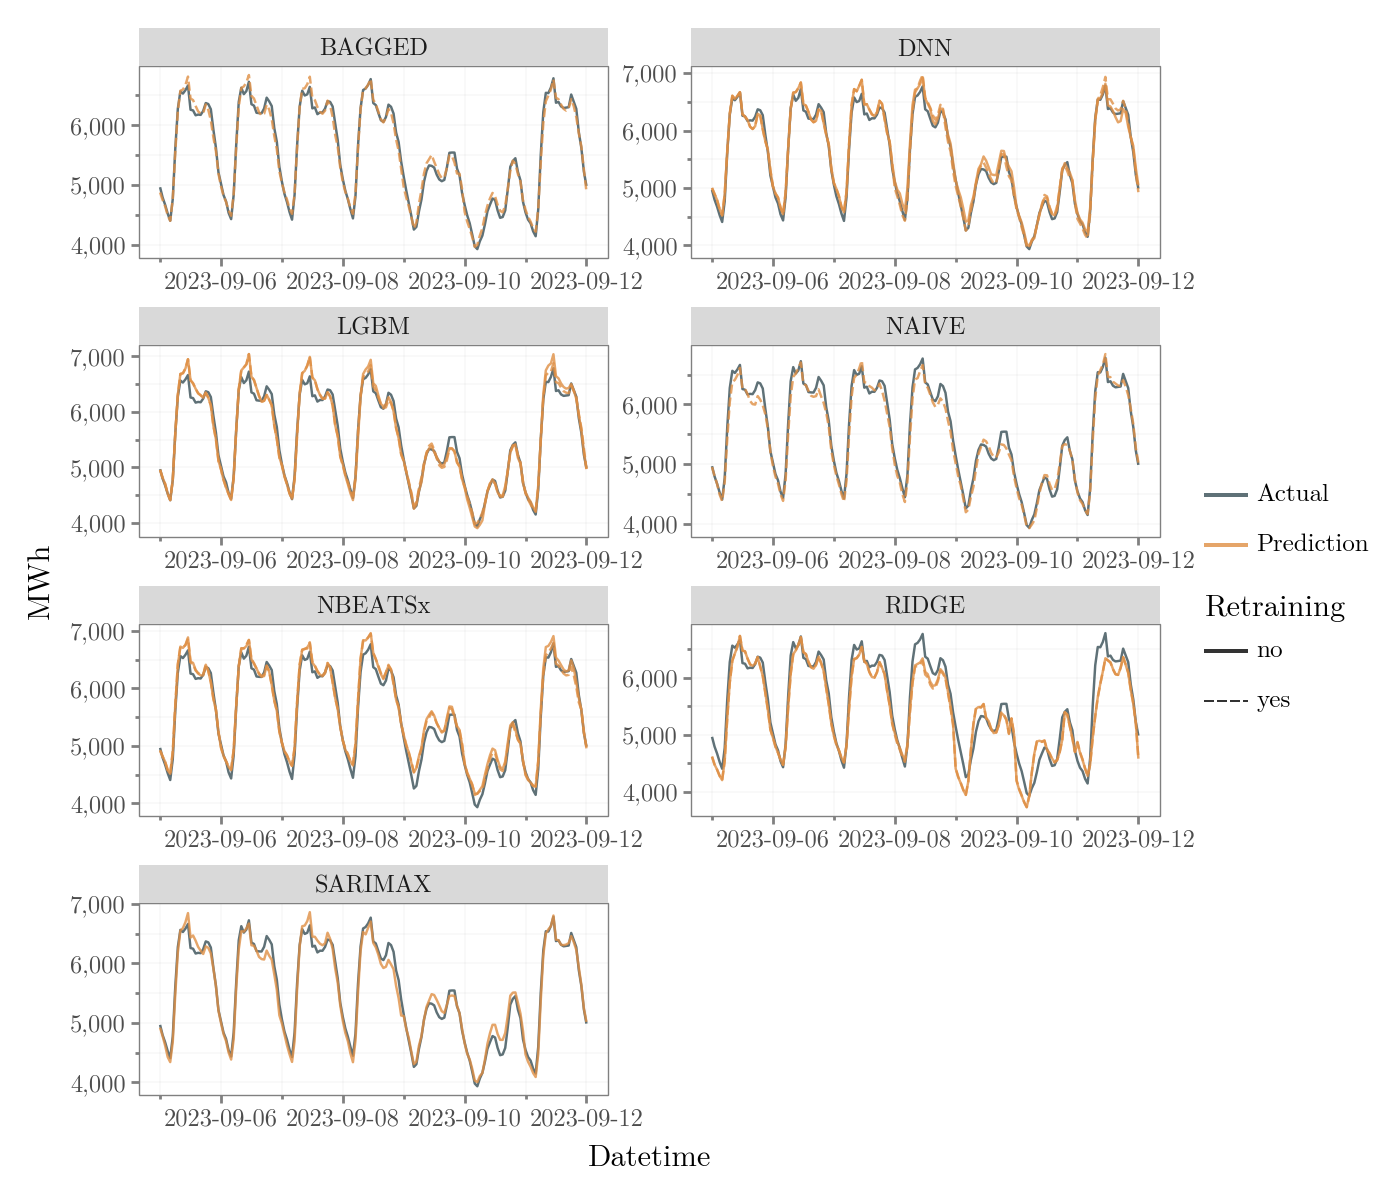

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 6 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/holdout_preds_good_week.pdf


In [257]:
plot_width = 7
plot_height = 6

fig = (
    pn.ggplot(
        data=(
            pl.from_pandas(results)
            # only keep the target week
            .filter(pl.col("datetime") >= pd.to_datetime("2023-09-05"))
            .filter(pl.col("datetime") <= pd.to_datetime("2023-09-12"))
            .unpivot(index=["datetime", "model", "retraining"])
            # convert to MWh for plot size
            .with_columns(pl.col("value") / 1000)
            # Make sure actual is never dotted line
            .with_columns(
                retraining=pl.when(pl.col("variable") == "kWh")
                .then(pl.lit("no"))
                .otherwise(pl.col("retraining"))
            )
            # Rename colour categories for plot
            .with_columns(
                variable=pl.when(pl.col("variable") == "kWh")
                .then(pl.lit("Actual"))
                .otherwise(pl.lit("Prediction"))
            )
        ),
        mapping=pn.aes("datetime", "value", colour="variable", linetype="retraining"),
    )
    + pn.geom_line(alpha=0.8)
    + pn.labs(y="MWh", x="Datetime", linetype="Retraining", colour="")
    + pn.facet_wrap("~ model", scales="free", ncol=2)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/holdout_preds_good_week.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

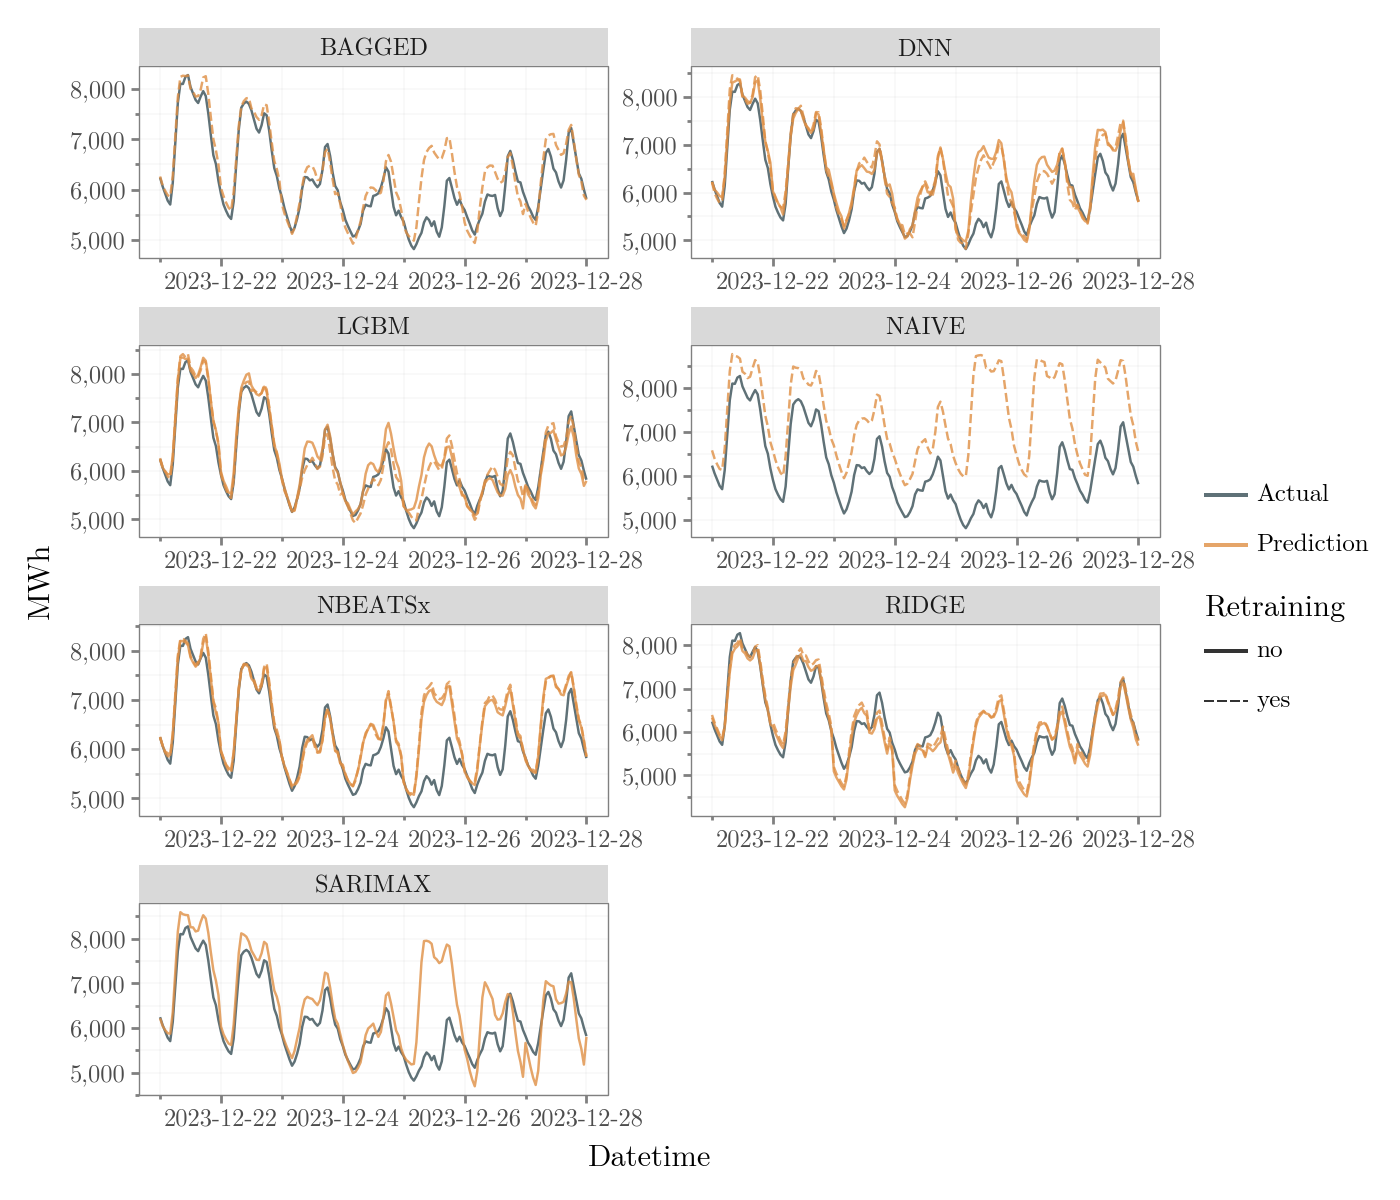

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 6 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/holdout_preds_bad_week.pdf


In [258]:
plot_width = 7
plot_height = 6

fig = (
    pn.ggplot(
        data=(
            pl.from_pandas(results)
            # only keep the target week
            .filter(pl.col("datetime") >= pd.to_datetime("2023-12-21"))
            .filter(pl.col("datetime") <= pd.to_datetime("2023-12-28"))
            .unpivot(index=["datetime", "model", "retraining"])
            # convert to MWh for plot size
            .with_columns(pl.col("value") / 1000)
            # Make sure actual is never dotted line
            .with_columns(
                retraining=pl.when(pl.col("variable") == "kWh")
                .then(pl.lit("no"))
                .otherwise(pl.col("retraining"))
            )
            # Rename colour categories for plot
            .with_columns(
                variable=pl.when(pl.col("variable") == "kWh")
                .then(pl.lit("Actual"))
                .otherwise(pl.lit("Prediction"))
            )
        ),
        mapping=pn.aes("datetime", "value", colour="variable", linetype="retraining"),
    )
    + pn.geom_line(alpha=0.8)
    + pn.labs(y="MWh", x="Datetime", linetype="Retraining", colour="")
    + pn.facet_wrap("~ model", scales="free", ncol=2)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/holdout_preds_bad_week.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

# Balancing Costs

Balancing costs are calculated in reference to the spot price.

BG long: receive a low price compared to spot, loss is difference to spot (framed as "loss" in the sense of the word: DA spot price - long price)
BG short: pay a high price compared to spot, loss is difference to spot (framed as "loss" in the sense of the word: short price - DA spot price)

Data required:

- Imbalance: Forecasted value compared to actual (include sign to make calculation easy)
- Spot Price: Day-Ahead Spot Prices for 2023-2024
- Balance Energy Prices for 2023 and 2024 (Swissgrid)

In [259]:
spot_prices = (
    pl.read_csv("../0_data/preprocessed/day_ahead_prices_ch.csv", try_parse_dates=True)
    .with_columns(
        date=pl.col("date")
        .dt.convert_time_zone("Europe/Zurich")
        .dt.replace_time_zone(None)
        .dt.cast_time_unit("ns")
    )
    .rename({"date": "datetime"})
)

spot_prices.head()

datetime,da_spot_ch_eur_mwh
datetime[ns],f64
2015-01-01 00:00:00,44.94
2015-01-01 01:00:00,43.43
2015-01-01 02:00:00,38.08
2015-01-01 03:00:00,35.47
2015-01-01 04:00:00,30.83


In [260]:
balance_prices = (
    pl.read_csv("../0_data/preprocessed/balance_energy_price.csv", try_parse_dates=True)
    .filter(pl.col("datetime") >= results["datetime"].min())
    .filter(pl.col("datetime") <= results["datetime"].max())
    .with_columns(
        date_hour=pl.col("datetime").dt.truncate("1h").dt.cast_time_unit("ns")
    )
)

balance_prices.head()

datetime,long_ct_kWh,short_ct_kWh,date_hour
datetime[μs],f64,f64,datetime[ns]
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00
2023-09-01 00:15:00,5.07,17.72,2023-09-01 00:00:00
2023-09-01 00:30:00,5.1,16.79,2023-09-01 00:00:00
2023-09-01 00:45:00,1.85,11.58,2023-09-01 00:00:00
2023-09-01 01:00:00,2.22,14.02,2023-09-01 01:00:00


In [261]:
bal_res_df = (
    balance_prices
    # Join the holdout predictions based on hour time stamp
    .join(pl.from_pandas(results), how="left", left_on="date_hour", right_on="datetime")
    .sort(["model", "datetime"])
    .join(spot_prices, how="left", left_on="date_hour", right_on="datetime")
    .drop_nulls(subset="da_spot_ch_eur_mwh")
    .with_columns(
        da_spot_ch_ct_kwh=pl.col("da_spot_ch_eur_mwh") / 10,
        imbalance_kwh=(pl.col("pred") - pl.col("kWh")) / 4,
    )
    .with_columns(
        cost_eur=pl.when(pl.col("imbalance_kwh") >= 0)
        .then(
            pl.col("imbalance_kwh")
            * (pl.col("da_spot_ch_ct_kwh") - pl.col("long_ct_kWh"))
            / 100
        )
        .otherwise(
            pl.col("imbalance_kwh")
            * (pl.col("da_spot_ch_ct_kwh") - pl.col("short_ct_kWh"))
            / 100
        )
    )
    .with_columns(cost_eur_per_mwh=pl.col("cost_eur") / pl.col("kWh") * 1000)
)


bal_res_df.head()

datetime,long_ct_kWh,short_ct_kWh,date_hour,pred,kWh,model,retraining,da_spot_ch_eur_mwh,da_spot_ch_ct_kwh,imbalance_kwh,cost_eur,cost_eur_per_mwh
datetime[μs],f64,f64,datetime[ns],f64,f64,str,str,f64,f64,f64,f64,f64
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,5.0159e6,4.9521e6,"""BAGGED""","""yes""",95.3,9.53,15945.412212,963.102898,0.194485
2023-09-01 00:15:00,5.07,17.72,2023-09-01 00:00:00,5.0159e6,4.9521e6,"""BAGGED""","""yes""",95.3,9.53,15945.412212,711.165385,0.143609
2023-09-01 00:30:00,5.1,16.79,2023-09-01 00:00:00,5.0159e6,4.9521e6,"""BAGGED""","""yes""",95.3,9.53,15945.412212,706.381761,0.142643
2023-09-01 00:45:00,1.85,11.58,2023-09-01 00:00:00,5.0159e6,4.9521e6,"""BAGGED""","""yes""",95.3,9.53,15945.412212,1224.607658,0.247292
2023-09-01 01:00:00,2.22,14.02,2023-09-01 01:00:00,4.8656e6,4.7894e6,"""BAGGED""","""yes""",92.84,9.284,19053.502234,1345.939398,0.281026


## Full year with holidays

Summary table:

In [262]:
with pd.option_context("display.max_rows", 500):
    print(
        bal_res_df.group_by(["model", "retraining"])
        .agg(
            # total_costs_eur=pl.col("cost_eur").sum(),
            pl.col("cost_eur").mean().alias("Average"),
            pl.col("cost_eur").sum().alias("Total"),
        )
        .sort("Average")
        .with_columns(
            ((pl.col("Total") / pl.col("Total").shift(-1) - 1))
            .fill_null(0)
            .alias("Improvement over Previous"),
        )
        .to_pandas()
    )

      model retraining       Average         Total  Improvement over Previous
0      LGBM         no   7471.227594  2.625165e+08                  -0.015459
1      LGBM        yes   7588.536800  2.666384e+08                  -0.043297
2    BAGGED        yes   7931.967286  2.787055e+08                  -0.044350
3       DNN         no   8300.074049  2.916397e+08                  -0.052308
4     RIDGE        yes   8758.193943  3.077367e+08                  -0.013344
5       DNN        yes   8876.646207  3.118987e+08                  -0.028659
6   SARIMAX         no   9138.545309  3.211011e+08                  -0.000606
7     RIDGE         no   9144.089077  3.212959e+08                  -0.112827
8   NBEATSx        yes  10306.994294  3.621569e+08                  -0.031460
9   NBEATSx         no  10641.781063  3.739203e+08                  -0.301925
10    NAIVE        yes  15244.471993  5.356450e+08                   0.000000


Cumulative balance costs:

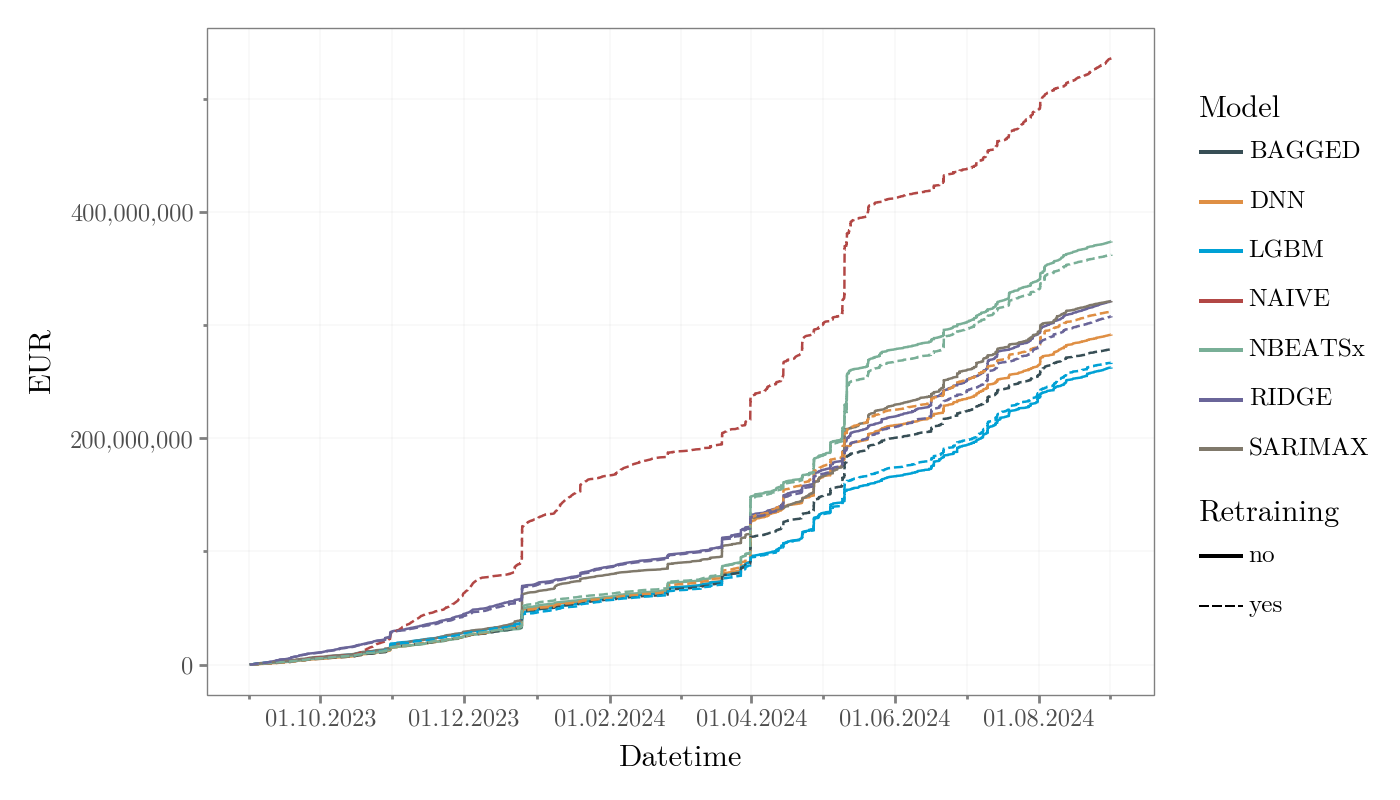

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/cum_balance_energy_with_holidays.pdf


In [264]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df
            # .filter(pl.col("model") != "NAIVE")
            .sort(["model", "retraining", "datetime"]).with_columns(
                pl.col("cost_eur").cum_sum().over(["model", "retraining"])
            )
        )
    )
    + pn.geom_step(
        mapping=pn.aes(
            x="datetime", y="cost_eur", colour="model", linetype="retraining"
        )
    )
    + pn.labs(y="EUR", x="Datetime", colour="Model", linetype="Retraining")
    + pn.scale_x_datetime(date_breaks="2 months", date_labels="%d.%m.%Y")
    + pn.scale_y_continuous(labels=comma_format())
    + pn.scale_colour_manual(values=jama_colour)
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/cum_balance_energy_with_holidays.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Full year without holidays

In [265]:
import holidays

# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=bal_res_df["datetime"].dt.year().unique().to_list(), prov=prov
)
regional_holidays

{datetime.date(2024, 1, 1): 'Neujahrestag', datetime.date(2024, 5, 9): 'Auffahrt', datetime.date(2024, 8, 1): 'Nationalfeiertag', datetime.date(2024, 12, 25): 'Weihnachten', datetime.date(2024, 1, 2): 'Berchtoldstag', datetime.date(2024, 3, 29): 'Karfreitag', datetime.date(2024, 4, 1): 'Ostermontag', datetime.date(2024, 5, 1): 'Tag der Arbeit', datetime.date(2024, 5, 20): 'Pfingstmontag', datetime.date(2024, 12, 26): 'Stephanstag', datetime.date(2023, 1, 1): 'Neujahrestag', datetime.date(2023, 5, 18): 'Auffahrt', datetime.date(2023, 8, 1): 'Nationalfeiertag', datetime.date(2023, 12, 25): 'Weihnachten', datetime.date(2023, 1, 2): 'Berchtoldstag', datetime.date(2023, 4, 7): 'Karfreitag', datetime.date(2023, 4, 10): 'Ostermontag', datetime.date(2023, 5, 1): 'Tag der Arbeit', datetime.date(2023, 5, 29): 'Pfingstmontag', datetime.date(2023, 12, 26): 'Stephanstag'}

In [266]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": [
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
        ],
        "holiday_date": [
            # Osterferienzeit
            "2024-03-27",
            "2024-03-28",
            "2024-03-29",
            "2024-03-30",
            "2024-03-31",
            # Auffahrtferienzeit
            "2024-05-08",
            "2024-05-09",
            "2024-05-10",
            "2024-05-11",
            "2024-05-12",
        ],
    }
).with_columns(pl.col("holiday_date").str.to_date())

holiday_df = (
    pl.concat(
        [
            holiday_df,
            holiday_manual_df,
        ],
        how="vertical",
    )
    .sort("holiday_date")
    .unique("holiday_date")
)

holiday_df

holiday_name,holiday_date
str,date
"""Neujahrestag""",2023-01-01
"""Berchtoldstag""",2023-01-02
"""Karfreitag""",2023-04-07
"""Ostermontag""",2023-04-10
"""Tag der Arbeit""",2023-05-01
…,…
"""Auffahrtferienzeit""",2024-05-12
"""Pfingstmontag""",2024-05-20
"""Nationalfeiertag""",2024-08-01


Summary table:

In [267]:
with pd.option_context("display.max_rows", 500):
    print(
        bal_res_df.filter(
            ~pl.col("datetime").dt.date().is_in(holiday_df["holiday_date"])
        )
        .group_by(["model", "retraining"])
        .agg(
            # total_costs_eur=pl.col("cost_eur").sum(),
            pl.col("cost_eur").mean().alias("Average"),
            pl.col("cost_eur").sum().alias("Total"),
        )
        .sort("Average")
        .with_columns(
            ((pl.col("Total") / pl.col("Total").shift(-1) - 1))
            .fill_null(0)
            .alias("Improvement over Previous"),
        )
        .to_pandas()
    )

      model retraining       Average         Total  Improvement over Previous
0    BAGGED        yes   5764.716078  1.926165e+08                  -0.031904
1       DNN         no   5954.693105  1.989642e+08                  -0.059415
2       DNN        yes   6330.839910  2.115324e+08                  -0.005652
3      LGBM        yes   6366.826747  2.127348e+08                  -0.027113
4   NBEATSx        yes   6544.262454  2.186634e+08                  -0.004654
5      LGBM         no   6574.863888  2.196859e+08                  -0.004921
6   NBEATSx         no   6607.377441  2.207723e+08                  -0.019175
7   SARIMAX         no   6736.552538  2.250884e+08                  -0.106363
8     RIDGE        yes   7538.355436  2.518791e+08                  -0.033493
9     RIDGE         no   7799.590535  2.606077e+08                  -0.301978
10    NAIVE        yes  11173.844025  3.733517e+08                   0.000000


Cumulative balance costs:

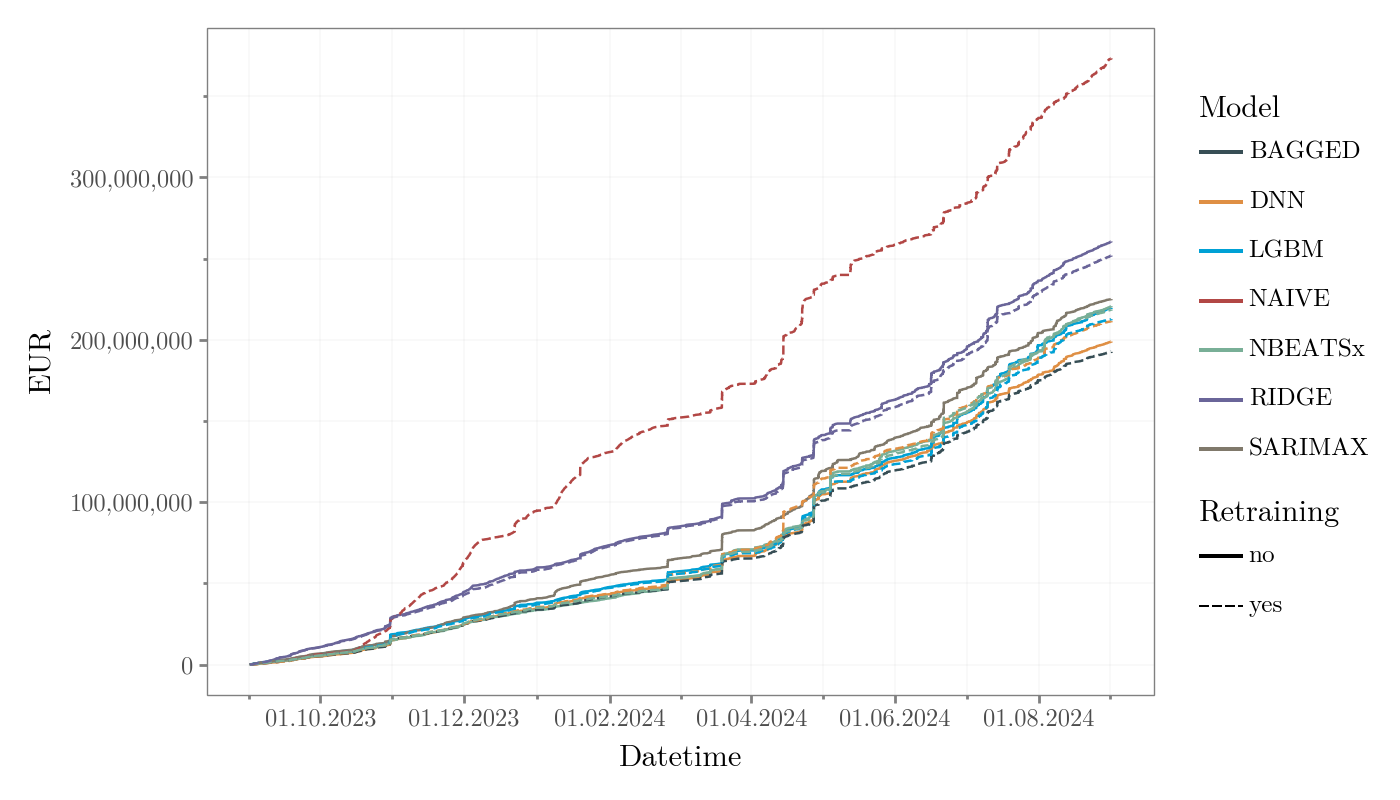

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/cum_balance_energy_without_holidays.pdf


In [268]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df.filter(
                ~pl.col("datetime").dt.date().is_in(holiday_df["holiday_date"])
            )
            .sort(["model", "retraining", "datetime"])
            .with_columns(pl.col("cost_eur").cum_sum().over(["model", "retraining"]))
        )
    )
    + pn.geom_step(
        mapping=pn.aes(
            x="datetime", y="cost_eur", colour="model", linetype="retraining"
        )
    )
    + pn.labs(y="EUR", x="Datetime", colour="Model", linetype="Retraining")
    + pn.scale_x_datetime(date_breaks="2 months", date_labels="%d.%m.%Y")
    + pn.scale_y_continuous(labels=comma_format())
    + pn.scale_colour_manual(values=jama_colour)
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/cum_balance_energy_without_holidays.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## By Calendar Variable

- by hour in day
- by weekday
- by month

### Aggregated

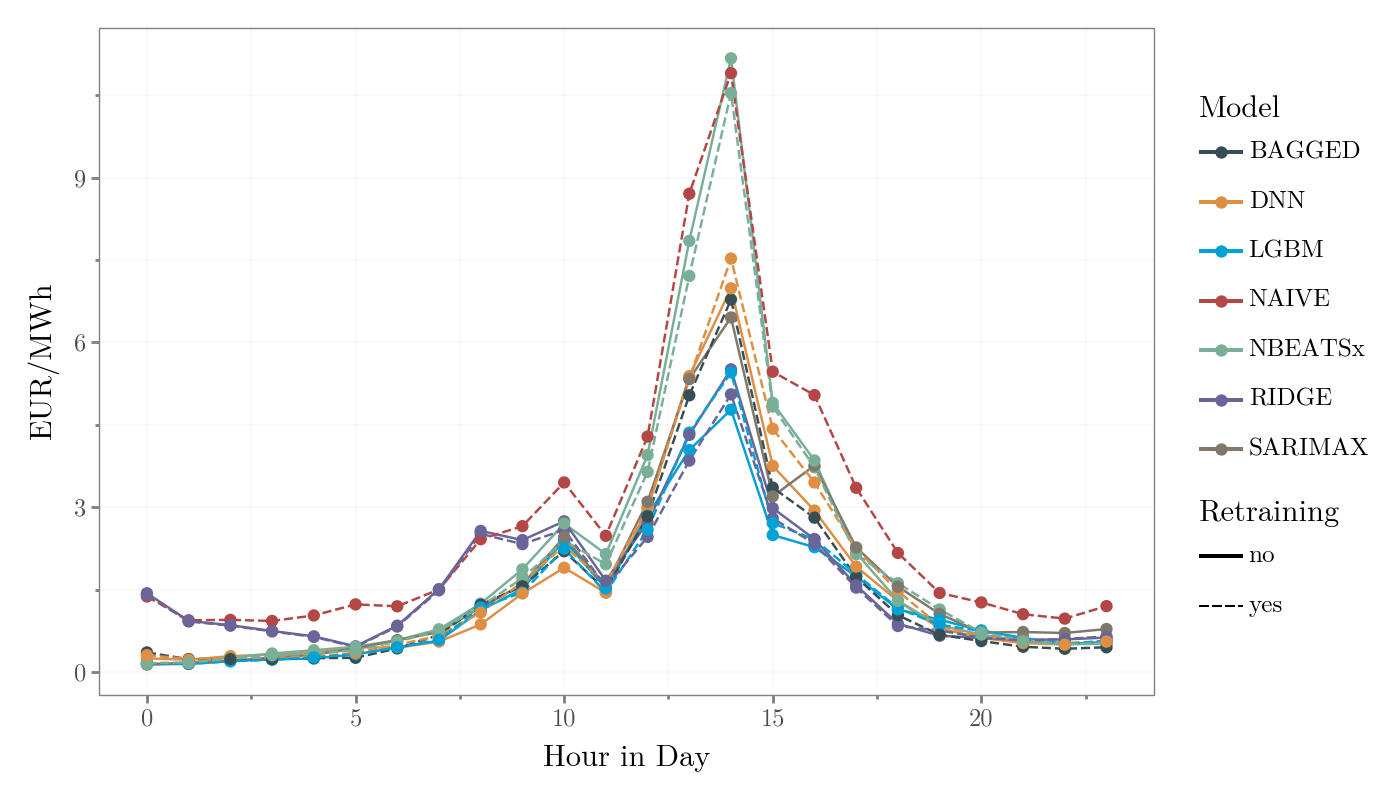

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/balance_cost_by_hour.pdf


In [269]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df.with_columns(hour=pl.col("datetime").dt.hour())
            .group_by(["hour", "model", "retraining"])
            .agg(pl.mean("cost_eur_per_mwh"))
        ),
        mapping=pn.aes(
            "hour", "cost_eur_per_mwh", colour="model", linetype="retraining"
        ),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        x="Hour in Day",
        y="EUR/MWh",
        colour="Model",
        linetype="Retraining",
    )
    + pn.scale_colour_manual(values=jama_colour)
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/balance_cost_by_hour.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

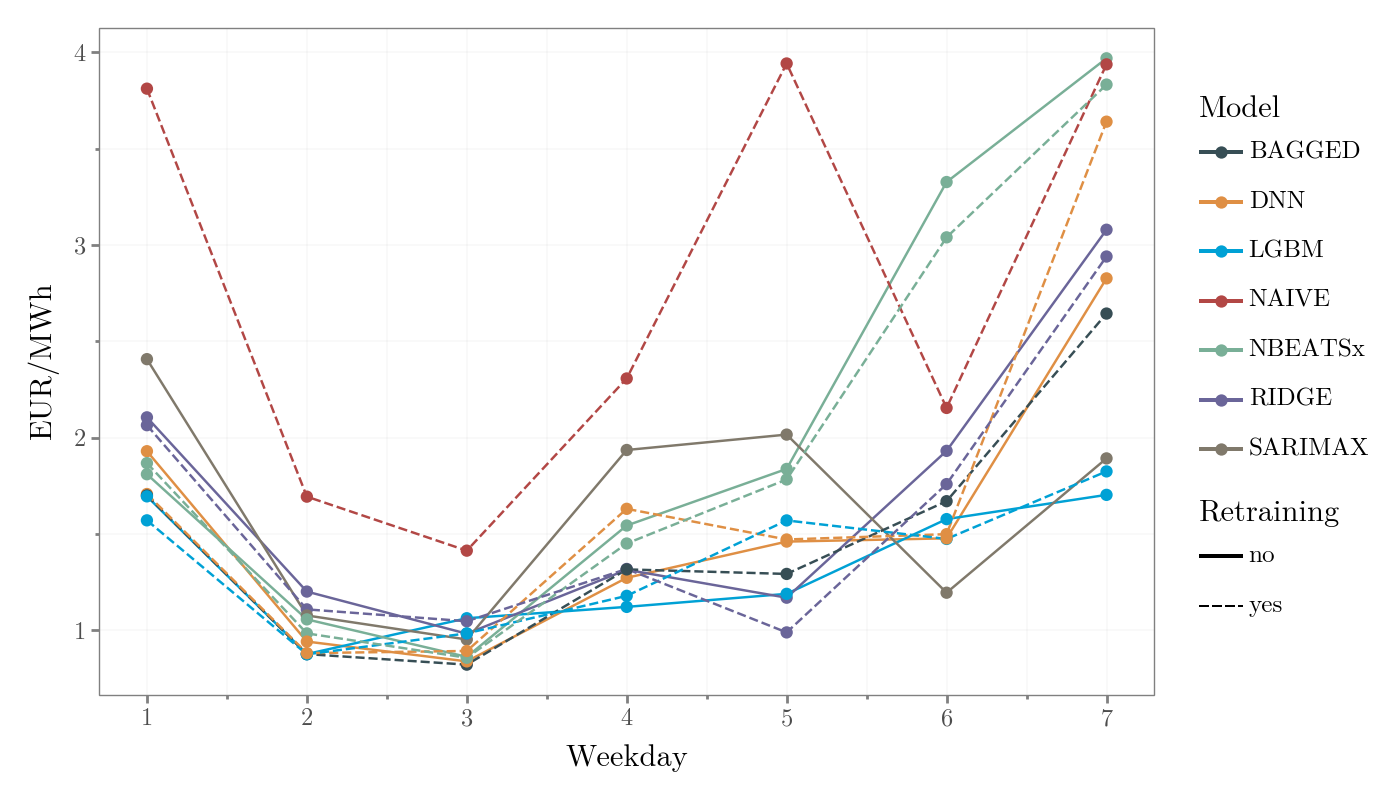

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/balance_cost_by_weekday.pdf


In [270]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df.with_columns(weekday=pl.col("datetime").dt.weekday())
            .group_by(["weekday", "model", "retraining"])
            .agg(pl.mean("cost_eur_per_mwh"))
        ),
        mapping=pn.aes(
            "weekday", "cost_eur_per_mwh", colour="model", linetype="retraining"
        ),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        x="Weekday",
        y="EUR/MWh",
        colour="Model",
        linetype="Retraining",
    )
    + pn.scale_x_continuous(breaks=np.arange(1, 7 + 1))
    + pn.scale_colour_manual(values=jama_colour)
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/balance_cost_by_weekday.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

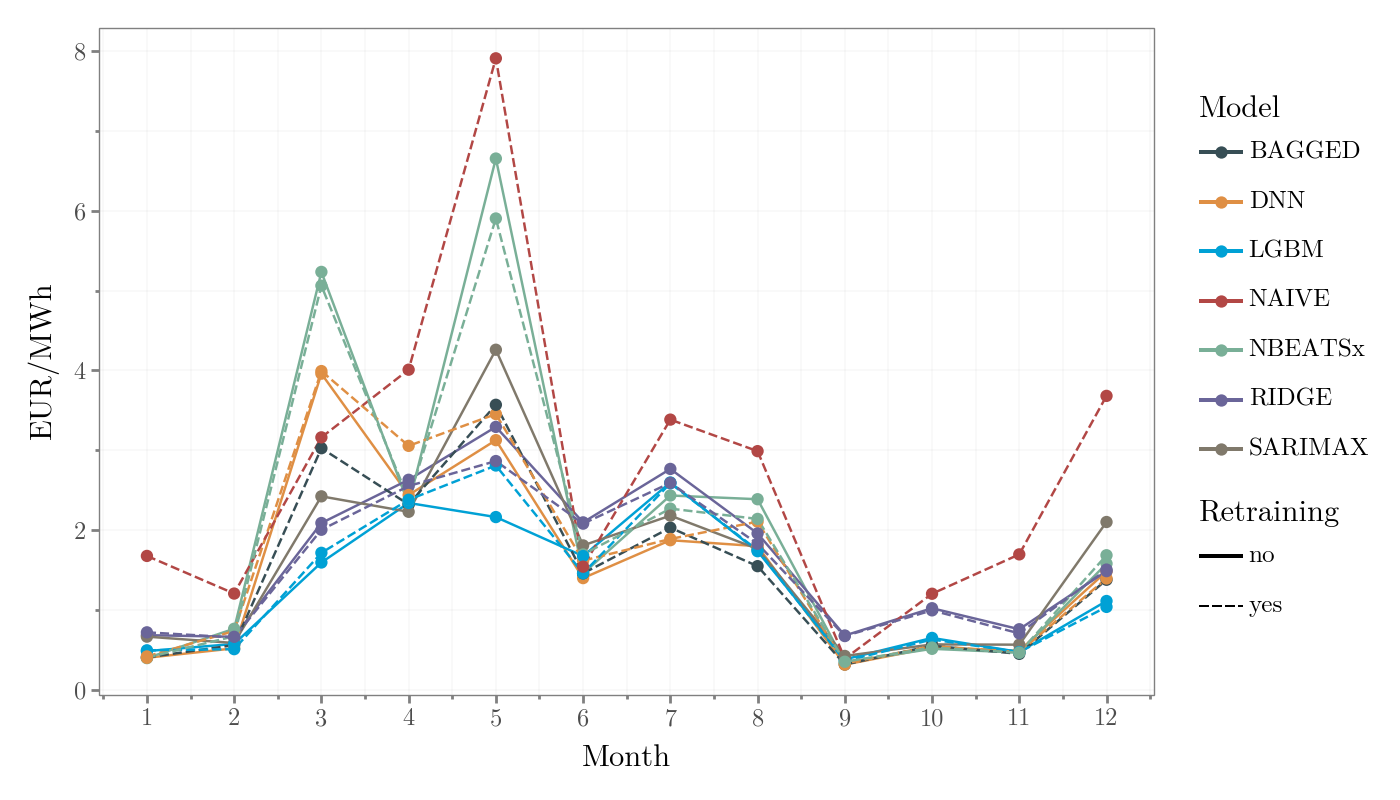

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/balance_cost_by_month.pdf


In [271]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df.with_columns(month=pl.col("datetime").dt.month())
            .group_by(["month", "model", "retraining"])
            .agg(pl.mean("cost_eur_per_mwh"))
        ),
        mapping=pn.aes(
            "month", "cost_eur_per_mwh", colour="model", linetype="retraining"
        ),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        x="Month",
        y="EUR/MWh",
        colour="Model",
        linetype="Retraining",
    )
    + pn.scale_x_continuous(breaks=np.arange(1, 12 + 1))
    + pn.scale_colour_manual(values=jama_colour)
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/balance_cost_by_month.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)